**Machine Learning and Analysis of Time Series - Smart City**
*   Introduction   
Based on the *Atmospheric Pollution Gas* and *Weather* time-series data captured by sensors deployed at Copenhague city in Danemark, updated every 30 minutes from 01/10/2020 to 31/10/2020, we firstly developed our research to analyze stationarity and seasonality of our time series, then applied statistical and machine/deep learning modules like SARIMAX, RNN to find the best model and make future predictions, finally created a DashBoard to visualize all the important information.
*   Data details   
  + *Atmospheric Pollution Gas* times series contains 7 types of pollution gas: NO2(µg/m³), NOx(µg/m³), CO(mg/m³), O3(µg/m³), PM10(µg/m³), PM25(µg/m³),  SO2(µg/m³).
  + *Weather* time series measures 5 indexes: Wind Direction, Wind speed(m/s), Temperature(°C), Relative Humidity(%), Solar radiation(W/m2).
*   Sensor information
  + Sensor Pollution1: located at H.C.Boulevard Andersens
  + Sensor Pollution2: located at Jagtvej
  + Sensor Pollution3: located at H.C.Ørsted Institutet 
  + Sensor Weather: located at H.C.Ørstedvej   
  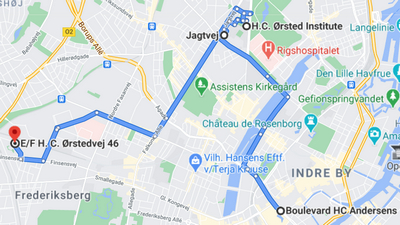   
  The four sensors above are closed to each one and another, in our case, we just used the data of Sensor Pollution1 and Weather.
*  Data source link: https://www.opendata.dk/city-of-copenhagen/luftforurening


**General steps to follow by SARIMAX**
+ Discovery
  + Importing libraries/modules and data, transforming date string to Datetime type and reindexing. 
  + Inspecting the data, checking the missing value and outliers, plotting the time series.
+ Processing
  + Filling the missing value if exist, applying a moving average to remove outliers if exist.
  + Decomposing the series to check trend and seasonality, transforming the series(to make mean and variance constant) if the series shows an upwards or downwards trend.
  + Applying statistical tests(ADFuller) to check if the series is stationary, if non-stationary, make it stationary by differencing.
  + Finding the best orders and seasonal orders
    + Manually
      + Based on differencing, fixing the difference order d and seasonal difference order D
      + Based on seasonality, fixing the seasonal lags. 
      + Plotting ACF of stationary series for MA order q, Seasonal MA order Q at seasonal spikes.
      + Plotting PACF of stationary series for AR order p, Seasonal AR order at seasonal spikes P.
    + Automatically
      + Using pmdarima module grid research
+ Training, forecasting and evaluation
  + Splitting data into the training set and testing set, normalizing if necessary.
  + Running SARIMA with those best parameters to fit the training set, checking for model validity using residual plots.
  + Making predictions on the testing set and evaluating the predictions by RMSE/R^2 for the regression problems or Accuracy/F1-score for the Classification problems.
+ Model selection and evaluation
  + Fine-tuning the model or applying the ensemble method to find a better model.


**Importing modules and libraries**

In [127]:
# Mounting drive
'''Mount google drive on google Colab in order to import files from google drive'''
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Change the working directory into the path where you place all the data files(.csv)
import os
path = "/content/drive/My Drive/Machine Learning/Smart city"
os.chdir(path)

# Upload custom function python file(.py) from your local computer
from google.colab import files
if os.path.exists(path + '/myfunc.py'): # File already existe
  from myfunc import *
else:
  print("Please upload your function file from your computer:")
  files.upload()
  from myfunc import *

# Common packages
import sys
import warnings
import itertools
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
import requests

# Statistic module packages
from statsmodels.tools.sm_exceptions import ConvergenceWarning # Ignore the warnings 
warnings.simplefilter('ignore', ConvergenceWarning)
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

# Scikit_learn and RNN module packages
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Mounted at /content/drive


**Data collection and cleaning**

In [ ]:
# Download the raw pollution data of sesonor H.C.Boulevard Andersens from DATA API
  # Call the API request
response = requests.get("https://admin.opendata.dk/api/3/action/datastore_search?resource_id=0eff5e34-7b08-4a9d-919d-e837b38af101")
print(response.status_code) # Print the status code, '200' means data exists 
if not os.path.exists('Pollution_Boulevard Andersens.csv'):
  open('Pollution_Boulevard Andersens.csv', 'w')
  for i in range(0,9):
    offset = 100 * i
    response = requests.get("https://admin.opendata.dk/api/3/action/datastore_search?offset="+ str(offset) + "&resource_id=0eff5e34-7b08-4a9d-919d-e837b38af101")
    res = response.json()['result']['records']
    f = csv.writer(open('Pollution_Boulevard Andersens.csv', 'a+'))
    for item in res:
      f.writerow([item['_id'], item['Date'], item['NOx myg/m3'], item['NO myg/m3'], item['NO2 myg/m3'], item['CO mg/m3'], item['O3 myg/m3'], item['SO2 myg/m3']])

# Download the raw pollution data of sesonor Jagtvej from DATA API
response = requests.get("https://admin.opendata.dk/api/3/action/datastore_search?resource_id=98275e9c-22da-4158-b44b-ac4844df8ab4")
print(response.status_code)
if not os.path.exists('Pollution_Jagtvej.csv'):
  open('Pollution_Jagtvej.csv', 'w')
  for i in range(0,9):
    offset = 100 * i
    response = requests.get("https://admin.opendata.dk/api/3/action/datastore_search?offset="+ str(offset) + "&resource_id=98275e9c-22da-4158-b44b-ac4844df8ab4")
    res = response.json()['result']['records']
    f = csv.writer(open('Pollution_Jagtvej.csv', 'a+'))
    for item in res:
      f.writerow([item['_id'], item['Dato'], item['Tid'], item['NO2 myg/m3'], item['NOx myg(NO2)/m3']])

# Download the raw pollution data of Ørsted Institutet from DATA API
response = requests.get("https://admin.opendata.dk/api/3/action/datastore_search?resource_id=6e8a8640-36f4-4140-8798-6fd48f08bce7")
print(response.status_code)
if not os.path.exists('Pollution_Ørsted Institutet.csv'):
  open('Pollution_Ørsted Institutet.csv', 'w')
  for i in range(0,8):
    offset = 100 * i
    response = requests.get("https://admin.opendata.dk/api/3/action/datastore_search?offset="+ str(offset) + "&resource_id=6e8a8640-36f4-4140-8798-6fd48f08bce7")
    res = response.json()['result']['records']
    f = csv.writer(open('Pollution_Ørsted Institutet.csv', 'a+'))
    for item in res:
          f.writerow([item['_id'], item['Date'], item['NOx myg/m3'], item['NO2 myg/m3'], item['CO mg/m3'], item['O3 myg/m3']])
		
# Download the raw pollution data of Ørstedvej from DATA API
response = requests.get("https://admin.opendata.dk/api/3/action/datastore_search?resource_id=3f02a45b-177e-4e57-8669-37d0265d2cc1")
print(response.status_code)
if not os.path.exists('Weather_Ørstedvej.csv'):
  open('Weather_Ørstedvej.csv', 'w')
  for i in range(0,15):
    offset = 100 * i
    response = requests.get("https://admin.opendata.dk/api/3/action/datastore_search?offset="+ str(offset) + "&resource_id=3f02a45b-177e-4e57-8669-37d0265d2cc1")
    res = response.json()['result']['records']
    f = csv.writer(open('Weather_Ørstedvej.csv', 'a+'))
    for item in res:
          f.writerow([item['_id'], item['Starttid'], item['VR'], item['VH (m/s)'], item['T (grader C)'], item['RH (%)'], item['GS (W/m2)']])

200
200
200
200


As the collected data is messy, shows different periods and some float numbers are even in form of the string, etc. We tackled it manually to make it clean, balanced, and appropriate to fit the model.

**>>>>Pollution data**



**Importing, inspecting and visualizing the data**

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1488 entries, 2020-10-01 00:00:00 to 2020-10-31 23:30:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NO2     1357 non-null   float64
 1   NOx     1357 non-null   float64
 2   O3      1327 non-null   float64
 3   CO      1357 non-null   float64
 4   SO2     1357 non-null   float64
 5   PM10    1286 non-null   float64
 6   PM2.5   1286 non-null   float64
dtypes: float64(7)
memory usage: 93.0 KB
None
>>> The first five lines of data: 
                        NO2    NOx     O3    CO   SO2  PM10  PM2.5
DateTime                                                         
2020-10-01 00:00:00   9.12  11.74  67.99  0.14  0.59  10.7    6.8
2020-10-01 00:30:00  13.62  16.98  65.40  0.15  0.35   9.9    6.4
2020-10-01 01:00:00   6.90   8.84  71.07  0.14  0.29  14.7    7.5
2020-10-01 01:30:00   7.11   9.33  70.35  0.14  0.19  14.0    8.2
2020-10-01 02:00:00   5.45   6.77  70.23  0.13 

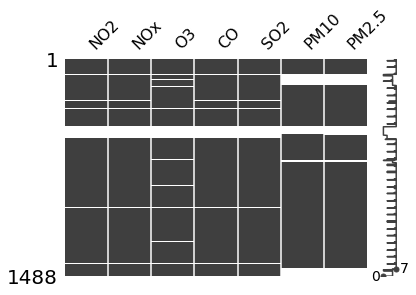

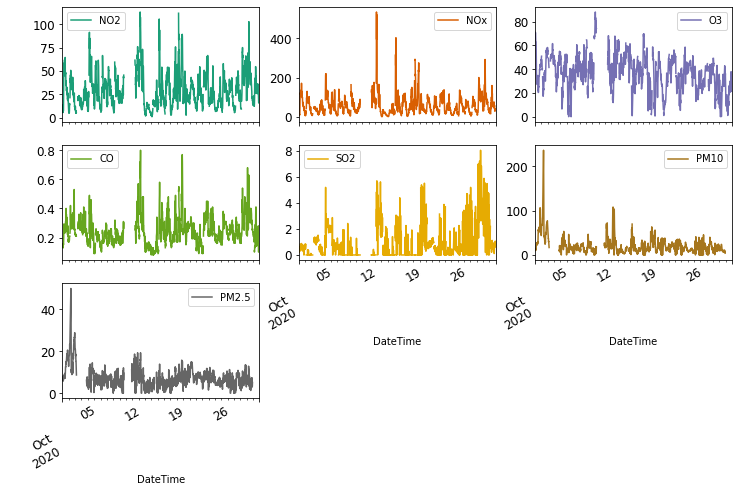

In [ ]:
# Importing pollution data
'''Setting 'parse_dates' and 'index_col' parameters to reindex the dataframe, transforming it into time series'''
Pol_BA = pd.read_csv("Pollution_Boulevard Andersens.csv", sep=',', names= ['DateTime','NO2', 'NOx', 'O3', 'CO', 'SO2', 'PM10', 'PM2.5'], header=0, parse_dates=['DateTime'], index_col='DateTime')

# Inspecting pollution data
'''Displaying the first five-line, checking the missing value and knowing more details by visualizing it'''
inspect_data(Pol_BA, visualize_missing_value=True)

# Display pollution data 
plot_data(Pol_BA)

**==>** From the above, we can see that there are some missing values for each column of pollution data.

**Filling the missing value**

In [ ]:
# Filling the missing value
Pol_BA = fill_missing_values(Pol_BA)

**Convert unit and label the pollution data by calculating AQI**
+ In order to report how polluted the air is. We should calculate the Air Quality Index(AQI) which is an air quality standard. Different countries have their own air quality indices, in our situation, we choose AQI of United States([Link](https://en.wikipedia.org/wiki/Air_quality_index)) which is divided into six categories indicating increasing levels of health concern and each category has its own representative color.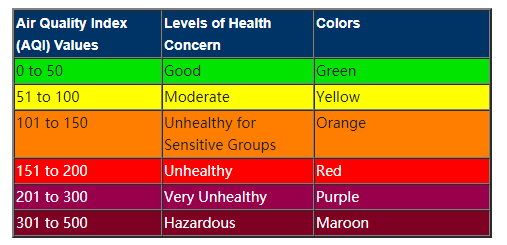
+ As the unit in the air quality standard table for (NO2, NOx, O3, O2) is ppb(Parts per billion by volume) instead of µg/m³(Micrograms of gaseous pollutant per cubic), so we need to at first convert the unit. While for PM2.5(µg/m³), PM10(µg/m³), CO(mg/m³), the unit is the same and we don't need to convert.
+ In order to normalize and visualize all the pollution concentration, we need to calculate AQI for each of them based on the mathematic formula proposed ([More detais in section 'Computing the AQI'](https://en.wikipedia.org/wiki/Air_quality_index)).

In [ ]:
# Convert pollutant concentration unit(just one time)
Pol_BA = conversion_to_ppb(Pol_BA)

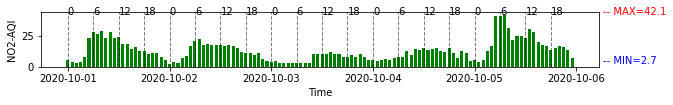

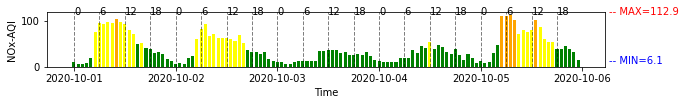

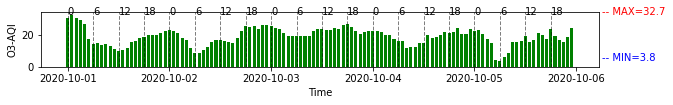

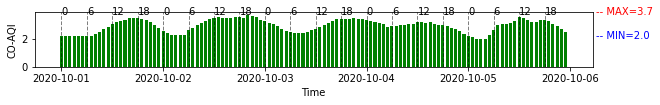

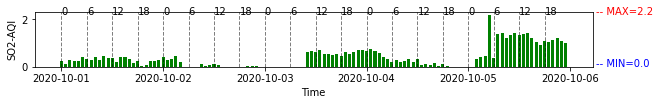

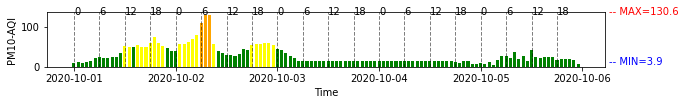

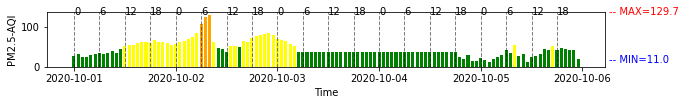

In [ ]:
# Display the Dashbord for a selected period
Air_Situation_Dashbord(Pol_BA, start_time=pd.to_datetime("2020-10-01 00:00:00"), end_time=pd.to_datetime("2020-10-05 23:30:00"), figsize=(10,1), width=0.03, min_max_distance=0.3)

**Trend and seasonality cheking**

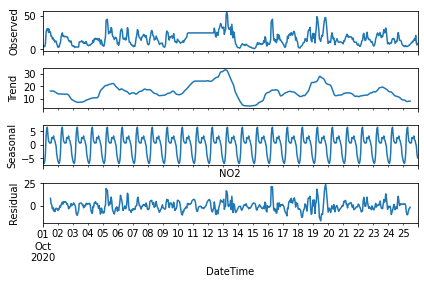

In [ ]:
# Select a period of time series and resample it by hours
Pol_BA_df = select_period_resample(Pol_BA, start_at=pd.to_datetime('2020-10-01 00:00:00'), end_at=pd.to_datetime('2020-10-25 23:30:00'), freq='H')

# Extract NO2
Pol_BA_df_NO2 = Pol_BA_df['NO2']

# Decompose the series
decompose_series(Pol_BA_df_NO2)

**==>**  Based on the plot above, we can conclude two points:
+ It has neither an upwards/downwards trend nor an exponential trend, so we don't need to do de-trending and logging respectively.
+ A daily seasonality is obvious, which means the seasonal lags could be 24(resampling by the hour).
+ The two peaks in the seasonal imply that some factors have a strong and regular influence on the NO2 concentration in the morning and evening, this could be traffic. We try to zoom it in to see daily changes and know more details about the right time when appearing the peak.

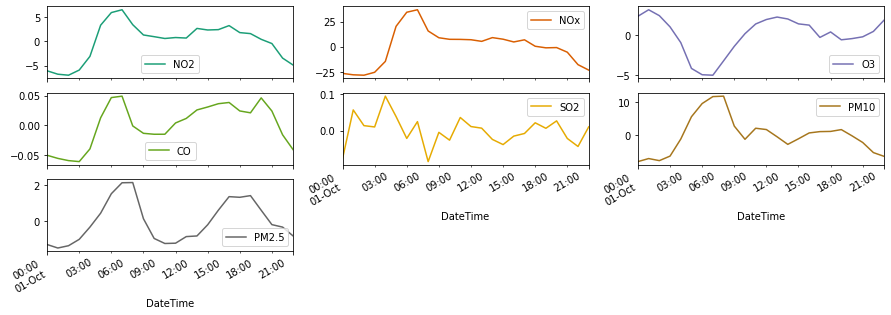

In [ ]:
# Return the seasonal DataFrame(of one or all columns) in order to zoom daily seasonal changes
seasonal = decompose_series(Pol_BA_df, return_seasonal=True)

# As each day follows the same seasonal pattern, here we just pick the first day 
seasonal['2020-10-01'].plot(subplots=True, layout=(3,3), figsize=(15,5), colormap='Dark2')
plt.show()

**==>** From the seasonal plot above, we can see that:
+ NO2 concentration increases during the period of 6h-8h, 13-14 and 17h-18h. Nox and Co follow the same pattern.
+ As we all know, there are often too many people commuting to work by car or by a motor during the two periods, which produces more and more pollutant. So we can suppose that traffic has an important influence on air quality.

**Stationary checking**   
Before going any further into our analysis, our series has to be made stationary so that it can be easier to analyze and possible to predict, which means the series should exhibit constant statistical properties over time:
1. Constant mean: exhibiting no upwards or downwards trend.
2. Constant variance: show no varying increasing or decreasing amplitude.   
3. Constant autocorrelation structure.
4. No periodic fluctuations(seasonality).

+ **Notice**
  + The stationary that we talk about in our cases is *Weak Stationary* with constant means and variances, which can be inspected in two ways:
    + Manually: visualize rolling means and variances
    + AdFuller test: based on p-value, to decide to reject or not the null hypothesis(not stationery) with a certain confidence level
  + Seasonal or cyclical patterns should be removed by subtracting periodical values. In our cases, the data is 24-hours seasonal, substracting the series with a 24-lag difference series will give a “flatter” series



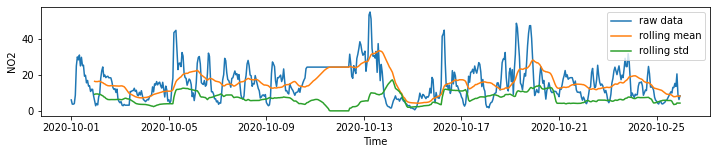

In [ ]:
# Plotting rolling means and variances by setting the window equal to seasonal lags
plot_rolling_means_variance(Pol_BA_df_NO2, window=24)

**==>** As the series shows both relatively constant means and variance, we can conclude that the series is very likely to be stationary.

In [ ]:
# Applying ADFuller test to check if the series is stationary
is_stationnary(Pol_BA_df_NO2)

Augmented Dickey-Fuller Test on NO2
Null Hypothesis: Data has unit root. Non-Stationary.
Test statistic = -6.184
P-value = 0.000
Critical values :
	1%: -3.441 ==> The data is  stationary with 99% confidence
	5%: -2.866 ==> The data is  stationary with 95% confidence
	10%: -2.569 ==> The data is  stationary with 90% confidence




**==>** As the P-value=0 < 0.05, we can reject the null hypothesis and confirm that series is stationary with 95% confidence.

**Autocorrelation plots (ACF & PACF)**   
Before we running the model SARIMA/SARIMAX, it is necessaire to find the best orders and seasonal orders (p, d, q) x (P, D, Q, Seasonal_lags) based on ACF & PACF plot manually or by pmdarima module automatic grid research:
+ An autocorrelation (ACF) plot represents the autocorrelation of the series with lags of itself.
+ A partial autocorrelation (PACF) plot represents the amount of correlation between a series and a lag of itself that is not explained by correlations at all lower-order lags.
+ We should always keep in mind that our model should be **parsimony** which means p+d+q+P+D+Q <= 6, to reduce the complexity and avoid overfitting.

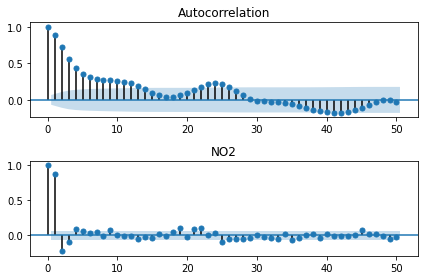

In [ ]:
# Visualize the acf and pacf to see if the autocorrelation structure of series is constant
acf_pacf_plot(Pol_BA_df_NO2, lags=50)

**==>** As we can see, the spikes of autocorrelation do not decrease to zero immediately and show a variant autocorrelation structure, because we haven't removed the seasonal patterns of our time series by differencing.

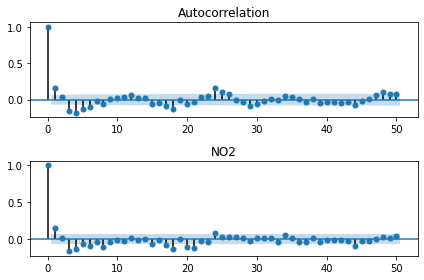

In [ ]:
# One-step differencing to find the differencing order d
acf_pacf_plot(transform_diff_log(Pol_BA_df_NO2), lags=50)

**==>** Adding a 1st order difference gives a sharp cutoff of the spike at lag value 1, so we don’t need to differentiate the series any further and consider that d could be 0 or 1.

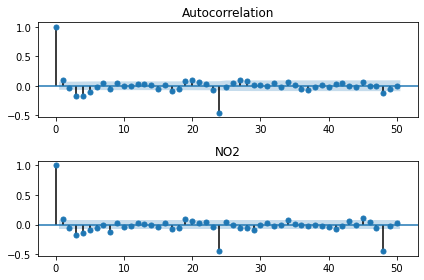

In [ ]:
# Applying seasonal differencing to find the seasonal differencing order D
acf_pacf_plot(transform_diff_log(transform_diff_log(Pol_BA_df_NO2), lags=24), lags=50)

**==>** After applying seasonal differencing, we can conclude that 
+ It gives us only seasonal spikes at lag-24 and lag-48, so we can consider that D could be 1 or 2.   
+ Based on the ACF plot, there is a sharp cutoff at lag-1. So we choose a MA order q=0,1 and MA seasonal order Q=0 or 1.
+ Based on the PACF plot, there is a sharp cutoff at lag-1. So we choose an AR order p=0,1 and AR seasonal order P=0, 1, 2 or 3.

**Splitting data**

In [ ]:
# Split the data into training set(before 2020-10-21) and testing set(rest)
Pol_BA_df_NO2_train, Pol_BA_NO2_test = train_test_split(Pol_BA_df_NO2, start_at='2020-10-01 00:00:00', end_at='2020-10-20 23:30:00')

**Model selection**   
Based on the orders and seasonal orders that we found, we can fit different models and compare their AICs to choose the one with minimal AIC:
+ Manually: creating a custom function, providing the range of orders and seasonal orders that we found above.
+ Automatically: calling the pmdarima module which returns directly the best orders and seasonal orders.

In [ ]:
# Get the best parameters manually
order, seasonal_order, AIC= grid_search_AIC_sarimax(Pol_BA_df_NO2, d=[0,1], D=[1,2], seasonal_lags=24, return_aic=True)
print(order,seasonal_order)

**==>** Based on the grid research manually:
+ We got the best parameters (1, 0, 2) (2, 1, 2, 24), which does not totally satisfy the parsimony principle but we can still apply it to SARIMAX model. 
+ Generally, it is too complicated and risky with manual methods to calculate the optimized orders for SARIMAX, despite we limit the range of values for certain orders, this calculation is quite long (several minutes)


In [ ]:
# Get the best parameters automatically
auto_sarimax_results = pm.auto_arima(Pol_BA_df_NO2_train, start_p=0, d=0, start_q=0, start_P=0, D=1, start_Q=0, max_p=1, max_q=1, max_P=3, max_Q=2, seasonal=True,
                  # The max order of the differencing and seasonal differencing
                  max_d=1, max_D=2,
                  # The period for seasonal differencing
                  m=24,
                  # Satisfy parsimony principle 
                  max_order=6,
                  stepwise=True, suppress_warnings=True, error_action='ignore')
order = auto_sarimax_results.order
seasonal_order = auto_sarimax_results.seasonal_order
print(order,seasonal_order)

(1, 0, 0) (3, 1, 0, 24)


**==>** Based on pmdarima module, the best parameters that we found is (1,0,0)x(3,1,0,24), which totally satsatisfied the analisis based on acf & pacf plot.




**Model fitting** 

                                 Statespace Model Results                                 
Dep. Variable:                                NO2   No. Observations:                  480
Model:             SARIMAX(1, 0, 0)x(3, 1, 0, 24)   Log Likelihood               -1350.630
Date:                            Sun, 20 Dec 2020   AIC                           2713.260
Time:                                    12:39:03   BIC                           2737.995
Sample:                                10-01-2020   HQIC                          2723.004
                                     - 10-20-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0575      0.256      0.225      0.822      -0.443       0.558
ar.L1          0.9038      0.021   

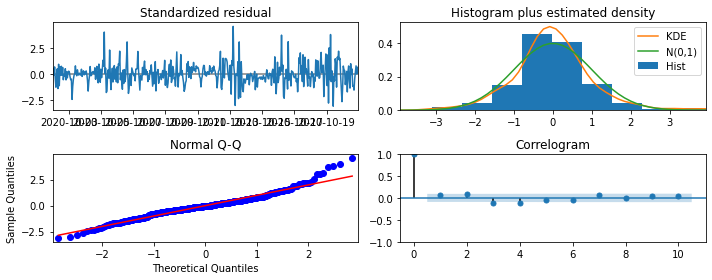

In [ ]:
# Run SARIMAX model
model_SARIMAX = fit_sarimax(Pol_BA_df_NO2_train, order=order, seasonal_order=seasonal_order, trend='c')

**=>** From the plot above, we can see that:
+ For the 'Standardized residual':  the residual is almost White noise except severals spikes are outliers can be ignored.
+ For the 'Histogram',  the distribution follows a gaussian normal distribution.
+ For the 'Normal Q-Q',  there is a systematic departure from normality.
+ For the 'Correlogram',  there is significant autocorrelation from the lag-3, which means the model could not be fully explained by the current coefficients obtained, but now we still assume that residual is White Noise and make in-sampling and out-of-sampling predictions, not considering the exogenous variables.

**Model evluation**   
We will firstly make **in-sampling predictions** of the training set for the last 96 hours(from 17th October to 21 October) in three cases:
+ **Case 1** - "one step ahead" prediction (SARIMA)
+ **Case 2** - "dynamic" prediction without exogenous factors (SARIMA)  


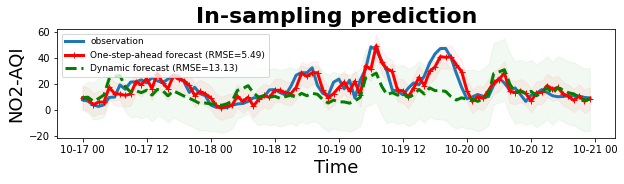

In [ ]:
# Make prediction and visualize the result
predict_plot_sarimax(model_SARIMAX, Pol_BA_df_NO2_train, start=-96)

**==>** From the prediction result, We can see that:
+ The prediction One-step-ahead prediction has well captured the characteristics of real data with rmse=5.49, but still shows some time shift differences between the predicted and real value.
+ The Dynamic prediction could well follow the daily trend of the real data with rmse=13.13, the underestimation of the peaks is probably due that we haven't yet taken into account the exogenous factors.






+ **Case 3** - "dynamic" prediction with exogenous factors (SARIMAX)

Before fitting the model, we should first explore the correlation between NO2 and other pollutants.

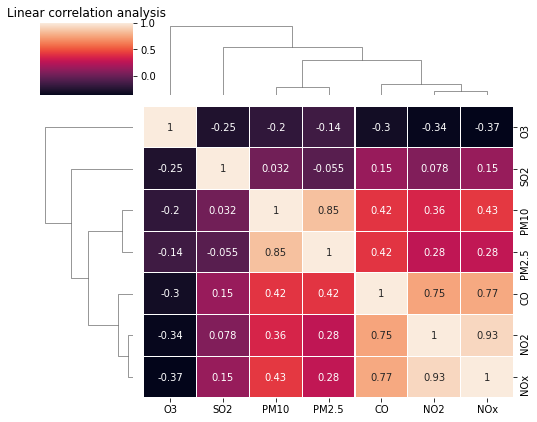

In [ ]:
correlation_analyse(Pol_BA_df_NO2, Pol_BA_df[['NOx', 'O3', 'CO', 'SO2', 'PM10', 'PM2.5']], figsize=(8,6))

**==>** The correlation analysis matrix above shows that there is a strong linear correlation between NO2 and NOx(0.93), CO(0.74) independently. We will now take them as exogenous factors to see if the predictions could be better by taking them into account.


(1, 0, 0) (3, 1, 0, 24)
                                 Statespace Model Results                                 
Dep. Variable:                                NO2   No. Observations:                  480
Model:             SARIMAX(1, 0, 0)x(3, 1, 0, 24)   Log Likelihood               -1074.352
Date:                            Sun, 20 Dec 2020   AIC                           2162.704
Time:                                    12:54:08   BIC                           2191.561
Sample:                                10-01-2020   HQIC                          2174.072
                                     - 10-20-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0433      0.127      0.341      0.733      -0.205       0.292
NOx        

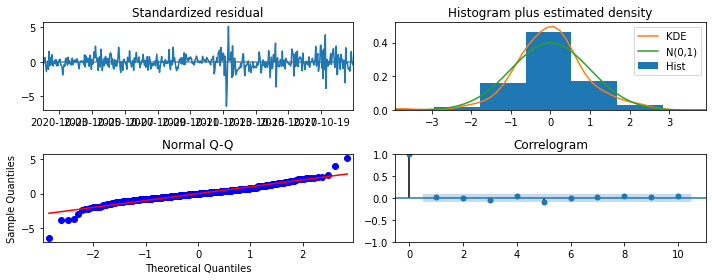

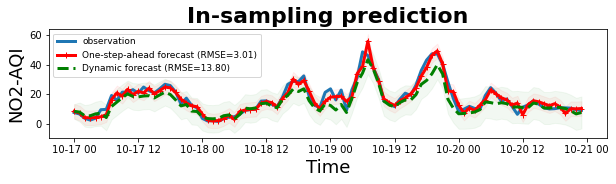

In [ ]:
# Split the data into training set(before 21th October) and testing set(rest)
Pol_BA_df_NOx_train, Pol_BA_df_NOx_test = train_test_split(Pol_BA_df['NOx'], start_at='2020-10-01 00:00:00', end_at='2020-10-20 23:30:00')

# Get the best parameters automatically by considering NOx as exogenous factor
auto_sarimax_results = pm.auto_arima(Pol_BA_df_NO2_train, X=Pol_BA_df_NOx_train, start_p=0, d=0, start_q=0, start_P=0, D=1, start_Q=0, max_p=1, max_q=1, max_P=3, max_Q=2, seasonal=True,
                  # The max order of the differencing and seasonal differencing
                  max_d=1, max_D=2,
                  # The period for seasonal differencing
                  m=24,
                  # Satisfy parsimony principle 
                  max_order=6,
                  stepwise=True, suppress_warnings=True, error_action='ignore')
order = auto_sarimax_results.order
seasonal_order = auto_sarimax_results.seasonal_order
print(order,seasonal_order)

# Run SARIMAX model by considering NOx as exogenous factor
model_SARIMAX_exo_NOx = fit_sarimax(Pol_BA_df_NO2_train, exog=Pol_BA_df_NOx_train, order=order, seasonal_order=seasonal_order, trend='c')

# Make prediction and visualize the result (from 17th December until 21th December)
predict_plot_sarimax(model_SARIMAX_exo_NOx, Pol_BA_df_NO2_train, start=-96)

==> As we can see:
+ Adding an exogenous factor did not change the value of best order and seasoanl order: (1, 0, 0)x(3, 1, 0, 24).
+ But after adding the NOx as an exogenous factor(has a strong correlation with NO2), the One-step-ahead forecast shows no longer time shift differences with a lower rmse=3.01 and the dynamic prediction could also better follow the real data with a bit worse estimation accuracy for a long period.

(1, 0, 1) (3, 1, 0, 24)
                                 Statespace Model Results                                 
Dep. Variable:                                NO2   No. Observations:                  480
Model:             SARIMAX(1, 0, 1)x(3, 1, 0, 24)   Log Likelihood               -1250.523
Date:                            Sun, 20 Dec 2020   AIC                           2517.047
Time:                                    13:14:19   BIC                           2550.026
Sample:                                10-01-2020   HQIC                          2530.038
                                     - 10-20-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0261      0.188      0.139      0.889      -0.342       0.394
CO         

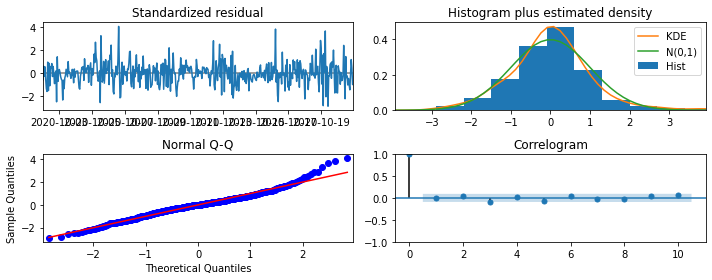

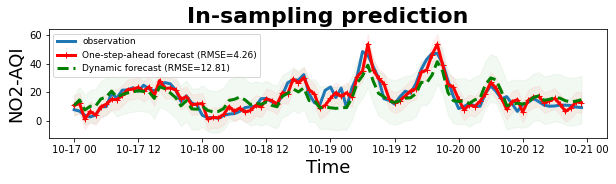

In [ ]:
# Split the stationary data into training set(before 21th Octover) and testing set(rest)
Pol_BA_df_CO_train, Pol_BA_df_CO_test = train_test_split(Pol_BA_df['CO'], start_at='2020-10-01 00:00:00', end_at='2020-10-20 23:30:00')

# Get the best parameters automatically by considering CO as exogenous factor
auto_sarimax_results = pm.auto_arima(Pol_BA_df_NO2_train,  X=Pol_BA_df_CO_train, start_p=0, d=0, start_q=0, start_P=0, D=1, start_Q=0, max_p=1, max_q=1, max_P=3, max_Q=2, seasonal=True,
                  # The max order of the differencing and seasonal differencing
                  max_d=1, max_D=2,
                  # The period for seasonal differencing
                  m=24,
                  # Satisfy parsimony principle 
                  max_order=6, 
                  stepwise=True, suppress_warnings=True, error_action='ignore')
order = auto_sarimax_results.order
seasonal_order = auto_sarimax_results.seasonal_order
print(order,seasonal_order)

# Run SARIMAX model by considering CO as exogenous factor
model_SARIMAX_exo_CO = fit_sarimax(Pol_BA_df_NO2_train, exog=Pol_BA_df_CO_train, order=order, seasonal_order=seasonal_order, trend='c')

# Make prediction and visualize the result (from 17th December until 21th December)
predict_plot_sarimax(model_SARIMAX_exo_CO, Pol_BA_df_NO2_train, start=-96)

**==>** We can see that by adding the CO as an exogenous factor, the One-step-ahead forecast also shows no longer time shift differences but with a higher rmse=4.43 while the dynamic prediction could also better follow the real data with higher estimation accuracy.

Now we will make **out-of-sampling** predictions on the testing set (from 21th Octover until 26th Octover) to evaluate the generalization capability(robustness) of our model.

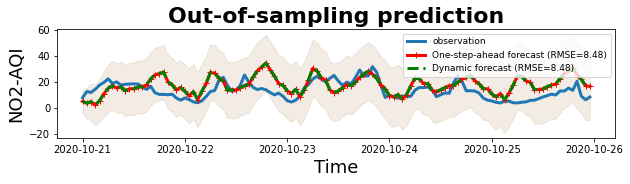

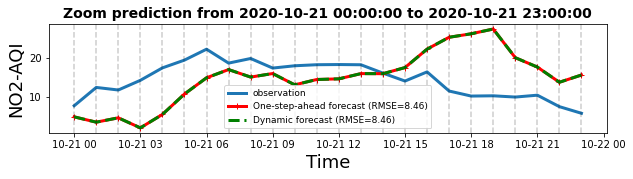

In [ ]:
# Out-of-sampling predictions without exogenous factor
predict_plot_sarimax(model_SARIMAX, Pol_BA_df_NO2_test, df_to_predict=Pol_BA_df_NO2_test, zoom=True, zoom_start_at='2020-10-21 00:00:00', zoom_end_at='2020-10-21 23:00:00')

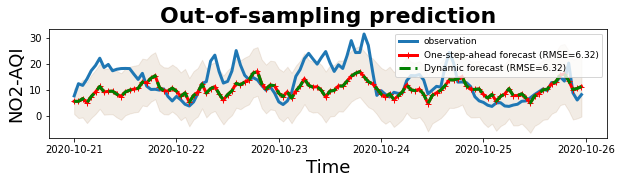

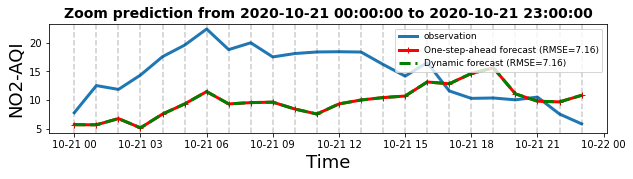

In [ ]:
# Out-of-sampling predictions with NOx exogenous factor
predict_plot_sarimax(model_SARIMAX_exo_NO, Pol_BA_df_NO2_test, df_to_predict=Pol_BA_df_NO2_test, exog=Pol_BA_df_NO2_test, zoom=True, zoom_start_at='2020-10-21 00:00:00', zoom_end_at='2020-10-21 23:00:00')

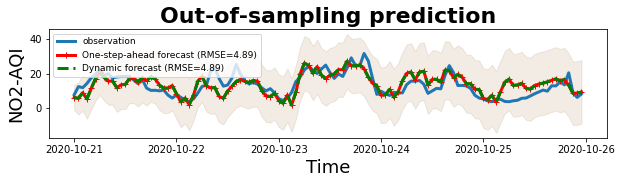

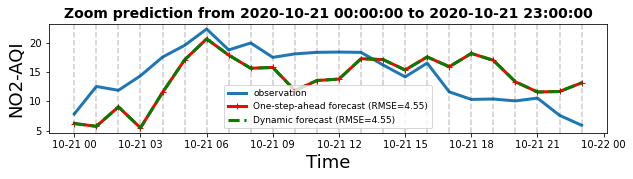

In [ ]:
# Out-of-sampling predictions with CO exogenous factor
predict_plot_sarimax(model_SARIMAX_exo_CO, Pol_BA_df_NO2_test, df_to_predict=Pol_BA_df_NO2_test, exog=Pol_BA_df_CO_test, zoom=True, zoom_start_at='2020-10-21 00:00:00', zoom_end_at='2020-10-21 23:00:00')

**==>** From the above, We can see that: 
+ There is no difference between One-step-ahead and the Dynamic method for out-of-sampling predictions(we can also say that there is only dynamic forecase for out-of-sampling data), our model performs well on the testing set.
+ Model with CO exogenous factor performes better than that with NO2 exogenous factor, better than model without exogenous factor.


**Normalize, remove volatility and Seasonality of the data**

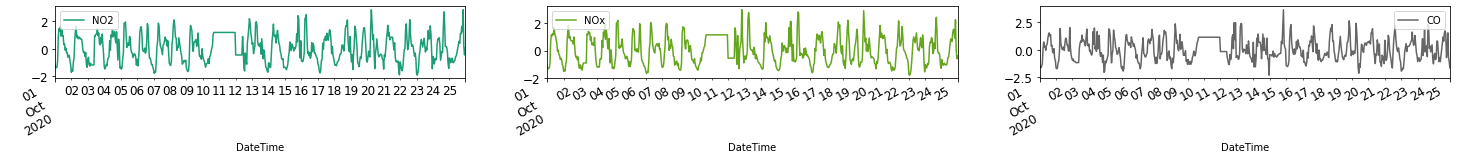

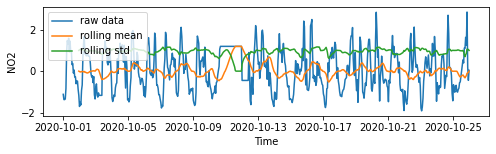

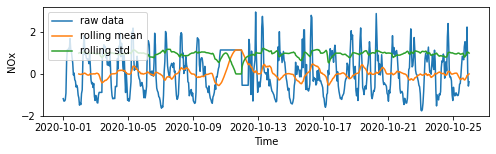

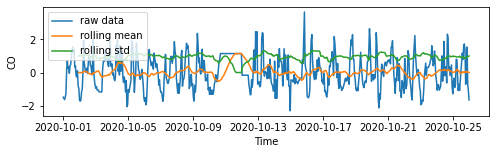

In [ ]:
# Copy the data
Pol_BA_df_copy = Pol_BA_df.copy()

# Normalize the data
Pol_BA_df_copy, Pol_BA_df_avgs, Pol_BA_df_devs = nomalize_data(Pol_BA_df_copy)

# Remove Increasing Volatility and Seasonality
Pol_BA_df_copy = remove_volatility_seasonality(Pol_BA_df_copy)

# Update the data
Pol_BA_df_trans = Pol_BA_df_copy[['NO2', 'NOx', 'CO']]

# Filling the missing value
Pol_BA_df_trans = fill_missing_values(Pol_BA_df_trans)

# Display the data
plot_data(Pol_BA_df_trans, figsize=(25,5))

# ACF and PACF plot
# acf_pacf_plot(Pol_BA_df_trans['NO2'], lags=50, acf=False)
# acf_pacf_plot(Pol_BA_df_trans['NOx'], lags=50, acf=False)
# acf_pacf_plot(Pol_BA_df_trans['CO'], lags=50, acf=False)

# Stationary checking by plotting rolling means and variances
plot_rolling_means_variance(Pol_BA_df_trans, window=24, figsize=(8,2))

# Extract 
Pol_BA_df_NO2_trans = Pol_BA_df_trans['NO2'].to_frame()
Pol_BA_df_NOx_trans = Pol_BA_df_trans['NOx'].to_frame()
Pol_BA_df_CO_trans = Pol_BA_df_trans['CO'].to_frame()

# Split the stationary data into training set(before 21th Octover) and testing set(rest)
Pol_BA_df_NO2_train, Pol_BA_df_NO2_test = train_test_split(Pol_BA_df_NO2_trans, start_at='2020-10-01 00:00:00', end_at='2020-10-20 23:30:00')
Pol_BA_df_NOx_train, Pol_BA_df_NOx_test = train_test_split(Pol_BA_df_NOx_trans, start_at='2020-10-01 00:00:00', end_at='2020-10-20 23:30:00')
Pol_BA_df_CO_train, Pol_BA_df_CO_test = train_test_split(Pol_BA_df_CO_trans, start_at='2020-10-01 00:00:00', end_at='2020-10-20 23:30:00')

**==>** After normalizing and removing the seasonality of our data, based on the pcaf plot, we can see NO2 and NOx show a model in AR(2) and CO shows a model in AR(1). The data is more stationary than before in terms of means and variances(Obviously, if we run ADF test to check the stationarity, we will get the same result).

**Take NOx as exogenous factor and run again the SARIMAX model**

                                 Statespace Model Results                                 
Dep. Variable:                                NO2   No. Observations:                  480
Model:             SARIMAX(1, 0, 0)x(3, 1, 0, 24)   Log Likelihood                 -57.718
Date:                            Thu, 07 Jan 2021   AIC                            129.437
Time:                                    15:36:17   BIC                            158.294
Sample:                                10-01-2020   HQIC                           140.804
                                     - 10-20-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0003      0.014     -0.021      0.983      -0.027       0.026
NOx            0.9067      0.018   

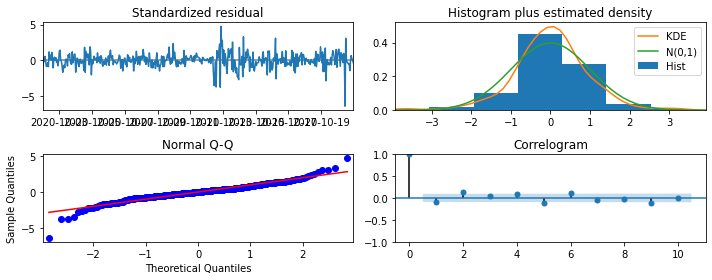

In [ ]:
# Using the same order and seasonal order
order = (1, 0, 0)
seasonal_order = (3, 1, 0, 24)

# Run SARIMAX model by considering NOx as exogenous factor
model_SARIMAX_exo_NOx = fit_sarimax(Pol_BA_df_NO2_train, exog=Pol_BA_df_NOx_train, order=order, seasonal_order=seasonal_order, trend='c')  

# Make in-sampling prediction and visualize the result (from 17th December until 21th December), returning the one-step-ahead and dynamique forecast result
prediction_osa_1, prediction_dyn_1 = predict_sarimax(model_SARIMAX_exo_NOx, start_at_in_sampling=-96, exog=Pol_BA_df_CO_test)

# Set the column name
prediction_osa_1.columns = ['NO2']
prediction_dyn_1.columns = ['NO2']

# Reconvert the data
prediction_osa_1 = Reconvert_prediction(df_to_convert=prediction_osa_1, df_trans=Pol_BA_df_copy, avgs=Pol_BA_df_avgs, devs=Pol_BA_df_devs)
prediction_dyn_1 = Reconvert_prediction(df_to_convert=prediction_dyn_1, df_trans=Pol_BA_df_copy, avgs=Pol_BA_df_avgs, devs=Pol_BA_df_devs)

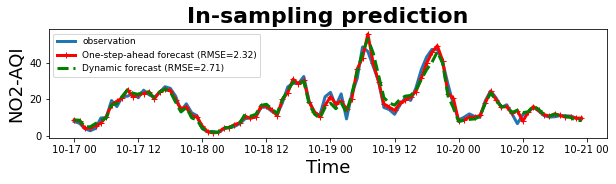

In [ ]:
# Make in-sampling prediction
prediction_plot_sarimax(df_original=Pol_BA_df['NO2'].loc['2020-10-17 00:00:00':'2020-10-20 23:00:00'], df_forecast=[prediction_osa_1, prediction_dyn_1], figsize=(10,2))

In [ ]:
# Make out-of-sampling prediction and visualize the result (from 21th December until 26th December)
prediction_dyn_out_1 = predict_sarimax(model=model_SARIMAX_exo_NOx, start_at_out_sampling='2020-10-21 00:00:00', end_at_out_sampling='2020-10-25 23:00:00', exog=Pol_BA_df_NOx_test)

# Set the column name
prediction_dyn_out_1.columns = ['NO2']

# Reconvert the data
prediction_dyn_out_1 = Reconvert_prediction(df_to_convert=prediction_dyn_out_1, df_trans=Pol_BA_df_copy, avgs=Pol_BA_df_avgs, devs=Pol_BA_df_devs)

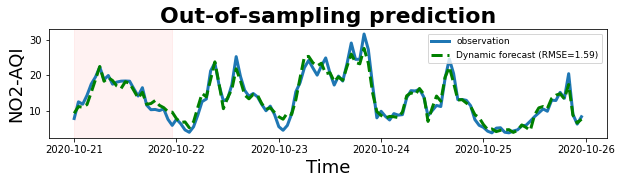

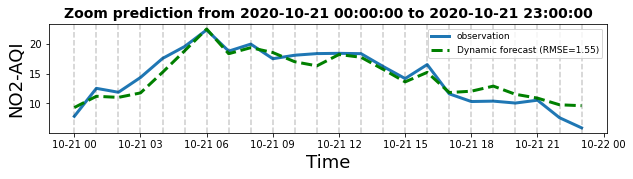

In [ ]:
# Make out-of-sampling prediction and zoom the result
prediction_plot_sarimax(df_original=Pol_BA_df['NO2'].loc['2020-10-21 00:00:00':'2020-10-25 23:00:00'], df_forecast=prediction_dyn_out_1, figsize=(10,2), zoom=True, zoom_start_at='2020-10-21 00:00:00', zoom_end_at='2020-10-21 23:00:00')

**==>** We cans see that the model performs better after normalizing the data by considering NOx as exogenous factor.

**Take CO as exogenous factor and run again the SARIMAX model**

In [ ]:
# Using the same order and seasonal order
order = (1, 0, 0)
seasonal_order = (3, 1, 0, 24)

# Run SARIMAX model by considering CO as exogenous factor
model_SARIMAX_exo_CO = fit_sarimax(Pol_BA_df_NO2_train, exog=Pol_BA_df_CO_train, order=order, seasonal_order=seasonal_order, trend='c')  

# Make in-sampling prediction and visualize the result (from 17th December until 21th December), returning the one-step-ahead and dynamique forecast result
prediction_osa_2, prediction_dyn_2 = predict_sarimax(model_SARIMAX_exo_CO, start_at_in_sampling=-96, exog=Pol_BA_df_CO_test)

# Set the column name
prediction_osa_2.columns = ['NO2']
prediction_dyn_2.columns = ['NO2']

# Reconvert the data
prediction_osa_2 = Reconvert_prediction(df_to_convert=prediction_osa_2, df_trans=Pol_BA_df_copy, avgs=Pol_BA_df_avgs, devs=Pol_BA_df_devs)
prediction_dyn_2 = Reconvert_prediction(df_to_convert=prediction_dyn_2, df_trans=Pol_BA_df_copy, avgs=Pol_BA_df_avgs, devs=Pol_BA_df_devs)

                                 Statespace Model Results                                 
Dep. Variable:                                NO2   No. Observations:                  480
Model:             SARIMAX(1, 0, 0)x(3, 1, 0, 24)   Log Likelihood                -329.708
Date:                            Thu, 07 Jan 2021   AIC                            673.416
Time:                                    15:43:13   BIC                            702.273
Sample:                                10-01-2020   HQIC                           684.783
                                     - 10-20-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0026      0.024     -0.106      0.915      -0.050       0.045
CO             0.3798      0.028   

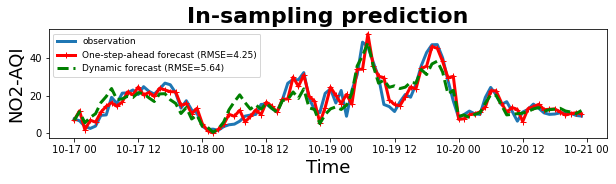

In [ ]:
# Make in-sampling prediction
prediction_plot_sarimax(df_original=Pol_BA_df['NO2'].loc['2020-10-17 00:00:00':'2020-10-20 23:00:00'], df_forecast=[prediction_osa_2, prediction_dyn_2], figsize=(10,2))

In [ ]:
# Make out-of-sampling prediction and visualize the result (from 21th December until 26th December)
prediction_dyn_out_2 = predict_sarimax(model=model_SARIMAX_exo_CO, start_at_out_sampling='2020-10-21 00:00:00', end_at_out_sampling='2020-10-25 23:00:00', exog=Pol_BA_df_CO_test)

# Set the column name
prediction_dyn_out_2.columns = ['NO2']

# Reconvert the data
prediction_dyn_out_2 = Reconvert_prediction(df_to_convert=prediction_dyn_out_2, df_trans=Pol_BA_df_copy, avgs=Pol_BA_df_avgs, devs=Pol_BA_df_devs)

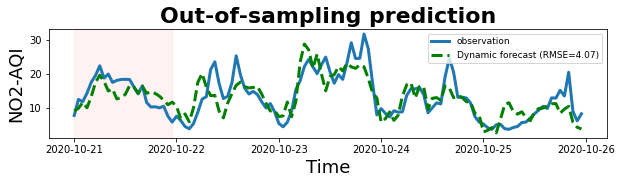

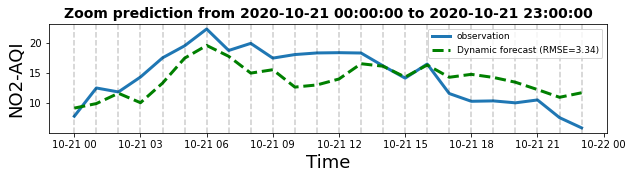

In [ ]:
# Make out-of-sampling prediction and zoom the result
prediction_plot_sarimax(df_original=Pol_BA_df['NO2'].loc['2020-10-21 00:00:00':'2020-10-25 23:00:00'], df_forecast=prediction_dyn_out_2, figsize=(10,2), zoom=True, zoom_start_at='2020-10-21 00:00:00', zoom_end_at='2020-10-21 23:00:00')

**==>** We cans see that the model performs worse if we take CO as exogenous factor after normalizing the data. As both NOx and CO influence NO2 predictions, it's interesting for us to take all them into account at the same time and see how they influence each other. Maybe we can take (NO2,CO) as an endogenous variable and take NOx as an exogenous variable, the result will be better. As SARIMAX module could only take one exogenous and one endogenous factor at once, we will now explore VAR(Vector Autoregression) to overcome this limit.


**VAR(Vector Autoregression)**
+ A multivariate forecasting algorithm that can be used when two or more time-series influence each other and this relationship is bi-directional.
+ In the VAR model, each variable is modeled as a linear combination of past values of itself and the past values of other variables in the system, which means we can predict the series with past values of itself along with other series in the system. If you have 5 time series that influence each other, we will have a system of 5 equations.
+ The VAR models are commonly used for forecasting (in the short term) systems of interrelated time series out of the sample, using the available theoretical information (extra-sample information) to build the contemporary relations among the endogenous variables of the model.
+ In this model, the forecasts are based on conditional expectations assuming an independent white noise vector εt. In other words, an h-step forecast at time t is:   
  + yt+h|t = c + Φ1 * yt+h–1|t + Φ2 * yt+h–2|t + …+ Φp * yt+h–p|t. (1)   
  The forecasts are computed recursively starting with h = 1:   
  + yt+1|T= c + Φ1 * yt + Φ2 * yt–1 + … + Φp * yt+1–p. (2)   
  Notice that for h = 1, the values of the lagged variables have to be obtained from the sample data, whereas for h > 2, the system will use its own predictions to carry out new predictions, so VAR predicition is **"dynamic forecast"**("Dynamic forecast" will take previously forecasted values while ""One-step-ahead forecast" will take actual values to make next step forecast).

+ Steps to follow:   
  + Analyze the time series characteristics (Done at the section '*Normalize, remove volatility and Seasonality of the data*')
  + Stationary checking and make the Time Series stationary if needed
  + Conintegration test
  + Test for causation amongst the time series
  + Split the Series into training and testing set
  + Find the Order(p)
  + Train the VAR Model with selected order p
  + Residuals correlation checking
  + Evaluate the model using test set
  + Roll back the transformations if any
  + Forecast to future


**Stationary checking**

We will still implement the ADF test for our purpose. If a series is found to be non-stationary, you make it stationary by differencing the series once and repeat the test until it becomes stationary.

In [ ]:
# Stationary checking
is_stationnary(Pol_BA_df_trans)

Augmented Dickey-Fuller Test on NO2
Null Hypothesis: Data has unit root. Non-Stationary.
Test statistic = -7.024
P-value = 0.000
Critical values :
	1%: -3.442 ==> The data is  stationary with 99% confidence
	5%: -2.867 ==> The data is  stationary with 95% confidence
	10%: -2.569 ==> The data is  stationary with 90% confidence


Augmented Dickey-Fuller Test on NOx
Null Hypothesis: Data has unit root. Non-Stationary.
Test statistic = -9.020
P-value = 0.000
Critical values :
	1%: -3.442 ==> The data is  stationary with 99% confidence
	5%: -2.866 ==> The data is  stationary with 95% confidence
	10%: -2.569 ==> The data is  stationary with 90% confidence


Augmented Dickey-Fuller Test on CO
Null Hypothesis: Data has unit root. Non-Stationary.
Test statistic = -10.186
P-value = 0.000
Critical values :
	1%: -3.441 ==> The data is  stationary with 99% confidence
	5%: -2.866 ==> The data is  stationary with 95% confidence
	10%: -2.569 ==> The data is  stationary with 90% confidence




**==>** Based on the ADF test, all the three series are confirmed to be  stationary. 

**Cointegration Test by Soren Johanssen**
+ For two or more time non-stationary series, if there exists a linear combination of them who is stationary by differencing, the collection of series is said to be cointegrated.  
+ Johansen test is a procedure for testing cointegration of several of order one integration I(1) time series, which means the non-stationary time series can be stationary after one-step differencing and shows in PACF plot that the autocovariance(autocorrelation) is decaying to 0 sufficiently quickly. 
+ If two or more time series are cointegrated, it means they have a long run, statistically significant relationship, which is the basic premise on which VAR models is based on.


In [ ]:
cointegration_test(Pol_BA_df_trans)

Name   |  Test Statistic | Critical Value(95%) | Cointegrated  
 ------------------------------------------------------------
NO2    |  248.93         | 24.2761             | True
NOx    |  158.58         | 12.3212             | True
CO     |  69.11          | 4.1296              | True


**==>** We can see that the NO2, NOx and  CO are cointegrated.

**Granger Causality to check the bi-directional relationship**   
+ Granger Causality tests is to see if changes in time series X will cause changes in time series Y and vice-vesa. It tests the Null Hypothesis that the coefficients of the corresponding past values is zero, that is, the X does not cause Y can be rejected..
+ if the p-value obtained from the test is lesser than the significance level of 0.05, we can safely reject the null hypothesis and conclude that the X causes Y.

In [ ]:
# Check for causality by returning p-value table
'''The rows are the response variable, columns are predictors. The values in the table are the p-values'''
grangers_causation_matrix(Pol_BA_df_trans[['NO2', 'NOx', 'CO']])

,NO2_x,NOx_x,CO_x
NO2_y,1.0000,0.0262,0.0607
NOx_y,0.0004,1.0000,0.0409
CO_y,0.0000,0.0000,1.0000


**==>** From the above, we can see that p-value at (NO2_x, NOx_y) is less than the significance level of 0.05, so we can say that NO2_x 'Granger causes' NOx_y. Same for other combinations and we can conclude that the three time series are interchangeably causing each other.

We will now select the right order(p) of the VAR model by iteratively fitting increasing orders of VAR model and picking the order that gives a model with least AIC. Though the usual practice is to look at the AIC, we can also check other best fit comparison estimates of BIC, FPE and HQIC.


**Select the Order(p)**

Before fitting the model, we should firstly split the dataset into training and test set. The VAR model will be fitted on the training set and then forecast the next testing set length long observations. These forecasts will be compared to the actuals present in the testing set.

In [ ]:
# Split the data into training set(before 2020-10-21) and testing set(rest)
Pol_BA_df_VAR_train, Pol_BA_df_VAR_test = train_test_split(Pol_BA_df_trans, start_at='2020-10-01 00:00:00', end_at='2020-10-20 23:30:00')

# Selecting best order based, setting 'NO2' and 'CO' as endogenous variable, 'NOx' as exogenous variable
model_VAR_1 = VAR(endog=Pol_BA_df_VAR_train[['NO2','CO']], exog=Pol_BA_df_VAR_train['NOx'])
order_VAR_1 = model_VAR_1.select_order(maxlags=12)
order_VAR.summary()

,AIC,BIC,FPE,HQIC
0,-1.504,-1.477,0.2222,-1.494
1,-3.783,-3.677,0.02275,-3.741
2,-4.002,-3.816*,0.01827,-3.929*
3,-4.005*,-3.740,0.01822*,-3.901
4,-3.996,-3.651,0.01838,-3.860
5,-3.982,-3.556,0.01866,-3.814
6,-3.987,-3.482,0.01856,-3.788
7,-3.975,-3.390,0.01878,-3.745
8,-3.961,-3.296,0.01905,-3.699
9,-3.935,-3.191,0.01955,-3.642


**==>** In the above output, the AIC drops to lowest at lag-2, then increases at lag-3 and then continuously drops further. We will go with the lag-2 model.

**Train the VAR Model with selected order p**

In [ ]:
# Fitting the model with order p=2
'''
  method='ols': using OLS to obtain estimates of coeffients equation by eqution
  verbose=True: print the AIC,BIC,FPE,HQIC selectd order by model 
'''
model_VAR_1 = model_VAR_1.fit(maxlags=2, method='ols', ic='aic', verbose=True) 

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 2, BIC -> 1, FPE -> 2, HQIC -> 2>
Using 2 based on aic criterion


**==>** From the lag order results, we can see that the selected orders for the model are AIC=2, BIC=1, FPE=2, HQIC=2. If we compare it with the output of the summary 'VAR Order Selection' above, we can see that all the orders drop to lowest at the selected order firstly, then increases at the next lag and then continuously drop further. It seems like a great order combination for us.

In [ ]:
# Print the model coeffients details
model_VAR_1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 08, Jan, 2021
Time:                     08:16:02
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.68200
Nobs:                     478.000    HQIC:                  -3.74552
Log likelihood:          -439.491    FPE:                  0.0226710
AIC:                     -3.78667    Det(Omega_mle):       0.0221124
--------------------------------------------------------------------
Results for equation NO2
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.002669         0.012588            0.212           0.832
exog0          0.823328         0.021264           38.719           0.000
L1.NO2         0.177479         0.033169            5.351           0.000
L1.CO          0


==> From the output, we got an equation for each variable based on the method OLS. For each table, if the column 'prob(p-value)' is greater than 0.05, we can eliminate this term from the equation by saying that it has no significant effect on the dependant variable and we can get the final model for each variable:
+ NO2,t = 0.823 * NOx,t + 0.177 * NO2,t-1
+ CO,t = 0.661 * NO2,t-1 - 0.179 * CO,t-1 + 0.454 * NO2,t-2

We can see that: 
+ ***NO2 is decided by the current value of exogenous variable NOx and the one-lagged value of itself***
+ ***CO is decided by the lagged value of NO2 and itself, have no relationship with NOx.***


**Residuals correlation checking**
+ It is important for us to check if there is any leftover pattern in the residuals(errors), ensuring that the model is sufficiently able to explain the variances and patterns in the time series.
+ If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model and we can try three actions mentioned above to tackle this problem:   
  + Increase the order: after trying all the possible orders, still shows a strong correlation
  + Induce more predictors: include more exogenous variable
  + Look for a different algorithm to model the time series

**==> Fortunately, The table 'Correlation matrix of residuals' above shows that there is no a strong correlation in residuals.**


**Evaluate the model**   
As we did for SARIMAX, we will first make the **In-sampling prediction** on the training data for the last 96 hours(from 17th October to 21 October).   
To forecast, the VAR model expects up to the lag order number of observations from the past data. This is because, the terms in *the* VAR model are essentially the lags of the various time series in the dataset, so we need to provide as many of the previous values as indicated by the lag order used by the model. We can consider the VAR forecast method as a **dynamic forecast**.


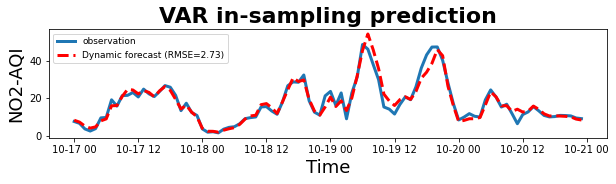

In [ ]:
# Get the lag order
lag_order = model_VAR_1.k_ar

# Prior data for forecasting
prior_data = Pol_BA_df_VAR_train[['NO2', 'CO']].values[384-lag_order:384]

# Forecast VAR model on the training set (from 17 October until 21 October)
prediction_in_sample = model_VAR_1.forecast(y=prior_data, steps=96, exog_future=Pol_BA_df_VAR_train['NOx'][384:])
prediction_in_sample = pd.DataFrame(prediction_in_sample, index=Pol_BA_df_VAR_train[384:].index, columns=['NO2','CO'])

# Reconvert the data
prediction_in_sample = Reconvert_prediction(df_to_convert=prediction_in_sample, df_trans=Pol_BA_df_copy, avgs=Pol_BA_df_avgs, devs=Pol_BA_df_devs)

# Visualize the predcition result
prediction_plot_var(Pol_BA_df['NO2']['2020-10-17 00:00:00':'2020-10-20 23:00:00'], prediction_in_sample['NO2'], title="VAR in-sampling prediction")

**==>** We can see that the VAR model performs better than the SARIMAX model on the training set, we continue to make **Out-of-sampling prediction** on the testing set. 

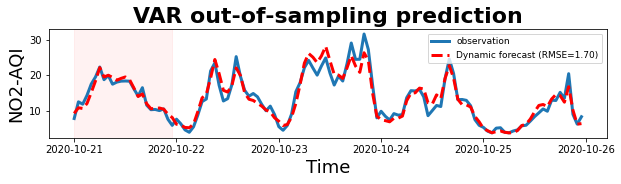

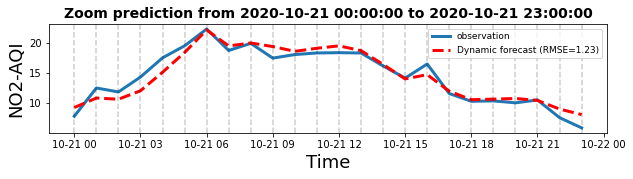

In [ ]:
# Get the lag order
lag_order = model_VAR_1.k_ar

# Prior data for forecasting
prior_data = Pol_BA_df_VAR_train[['NO2', 'CO']].values[-lag_order:]

# Forecast VAR model on the testing set for next 120 hours(from 21 October until 26 October)
prediction = model_VAR_1.forecast(y=prior_data, steps=120, exog_future=Pol_BA_df_VAR_test['NOx'])
prediction = pd.DataFrame(prediction, index=Pol_BA_df_VAR_test.index, columns=['NO2','CO'])

# Reconvert the data
prediction = Reconvert_prediction(df_to_convert=prediction, df_trans=Pol_BA_df_copy, avgs=Pol_BA_df_avgs, devs=Pol_BA_df_devs)

# Visualize the predcition result
prediction_plot_var(Pol_BA_df['NO2']['2020-10-21 00:00:00':'2020-10-25 23:00:00'], prediction['NO2'], zoom=True, zoom_start_at='2020-10-21 00:00:00', zoom_end_at='2020-10-21 23:00:00')

**==>** Based on the prediction plot, we have gotten the VAR model which is the best model for dynamic forecast, which performs almost as well as the SARIMAX model by also taking NOx as an exogenous variable. However, the advantage of VAR model is still obvious, more simple, faster and possible to predict two and more time series at the same time.

As we all know, the weather factor like the wind may also have some effect on the pollution concentration, we will now continue to explore the weather data and take it as an exogenous factor to see if we can find a better model.

**>>>>Weather data**

**Importing, inspecting and resampling the data**

In [ ]:
# Importing weather data
Weather = pd.read_csv("Weather_Ørstedvej.csv", sep=',', names= ['DateTime','VR','VH','T','RH','GS'], header=0, decimal=',', parse_dates=['DateTime'], index_col='DateTime').astype(float)

# Inspecting weather data
inspect_data(Weather)

# Select a period of time series and resample it by hours (from 1st October to 25 October)
Weather_df = select_period_resample(Weather, start_at=pd.to_datetime('2020-10-01 00:00:00'), end_at=pd.to_datetime('2020-10-25 23:30:00'), freq='H')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1488 entries, 2020-10-01 00:00:00 to 2020-10-31 23:30:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VR      1488 non-null   float64
 1   VH      1488 non-null   float64
 2   T       1488 non-null   float64
 3   RH      1488 non-null   float64
 4   GS      1488 non-null   float64
dtypes: float64(5)
memory usage: 69.8 KB
None
>>> The first five lines of data: 
                          VR    VH      T     RH    GS
DateTime                                             
2020-10-01 00:00:00  104.51  2.77  14.43  82.20  0.25
2020-10-01 00:30:00   96.42  3.19  14.50  81.71  0.28
2020-10-01 01:00:00   97.83  3.06  14.47  81.75  0.27
2020-10-01 01:30:00   92.89  3.11  14.38  83.89  0.27
2020-10-01 02:00:00   86.81  3.55  14.52  84.12  0.26


**==>** As we can see that all the columns of Weather data have no missing values, we will now analyze the correlation of weather data with pollution data.

**Correlation analysis**   
There are two methods to evaluate the correlation of times series:
+ Linear method: use the 'Pearson' coefficient
+ Non-linear method: use the 'spearsman' coefficient   

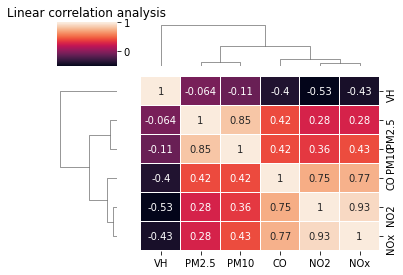

In [ ]:
correlation_analyse(Weather_df['VH'], Pol_BA_df[['NO2', 'NOx', 'CO', 'PM2.5', 'PM10']], method='pearson', figsize=(6,4))

**==>** From the plot above, we can conclude that there is a strong negative linear correlation for (VT, NO2), (VT, NOx), (VT, CO). 

**Apply the VAR model**

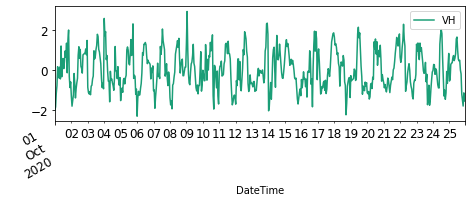

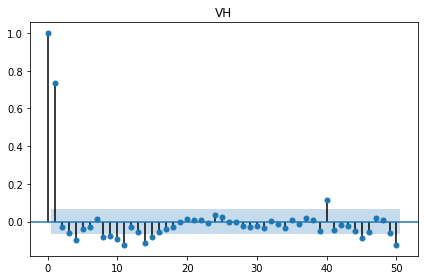

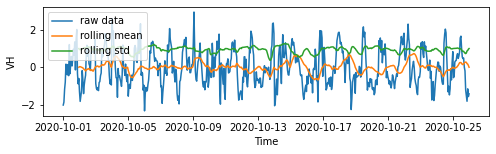

In [ ]:
# Copy the data
Weather_df_copy = Weather_df.copy()

# Normalize the data
Weather_df_copy, Weather_df_avgs, Weather_df_devs = nomalize_data(Weather_df_copy)

# Remove Increasing Volatility and Seasonality
Weather_df_copy = remove_volatility_seasonality(Weather_df_copy)

# Update the data
Weather_df_VAR_trans = Weather_df_copy['VH']

# Plot the data
plot_data(Weather_df_VAR_trans, figsize=(25,8))

# Plot the pacf of data
acf_pacf_plot(Weather_df_VAR_trans, lags=50, acf=False)

# Stationary checking by plotting rolling means and variances
plot_rolling_means_variance(Weather_df_VAR_trans, window=24, figsize=(8,2))

# Concactenante the data
Pol_weather_df_VAR = pd.concat([Pol_BA_df_trans, Weather_df_VAR_trans], axis=1)

# Filling the missing value
Pol_weather_df_VAR = fill_missing_values(Pol_weather_df_VAR)

# Split the data into training set(before 2020-10-21) and testing set(rest)
Pol_weather_df_VAR_train, Pol_weather_df_VAR_test = train_test_split(Pol_weather_df_VAR, start_at='2020-10-01 00:00:00', end_at='2020-10-20 23:30:00')

**==>** We can see that VH shows AR(1) model after being normalized and transformed.

**Select the Order(p)**

In [ ]:
# Selecting best order based, setting 'NO2' and 'NOx' as endogenous variable, 'VH' and 'CO' as exogenous variable
model_VAR_2 = VAR(endog=Pol_weather_df_VAR[['NO2','CO']], exog=Pol_weather_df_VAR[['NOx','VH']], freq='H')
order_VAR = model_VAR_2.select_order(maxlags=12)
order_VAR.summary()

,AIC,BIC,FPE,HQIC
0,-3.340,-3.295,0.03543,-3.323
1,-3.802,-3.727*,0.02233,-3.773*
2,-3.808,-3.703,0.02220,-3.767
3,-3.803,-3.669,0.02231,-3.751
4,-3.792,-3.628,0.02256,-3.728
5,-3.791,-3.598,0.02257,-3.716
6,-3.797,-3.573,0.02245,-3.710
7,-3.812*,-3.559,0.02211*,-3.713
8,-3.806,-3.523,0.02224,-3.696
9,-3.795,-3.482,0.02249,-3.673


**==>** In the above output, the AIC drops to lowest at lag-2, then increases at lag-3 and then continuously drops further. We will go with the lag-2 model.

In [ ]:
# Fitting the model with order p=2
model_VAR_2 = model_VAR_2.fit(maxlags=2, method='ols', ic='aic', verbose=True)
# Print the model coeffients details
model_VAR_2.summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 2, BIC -> 1, FPE -> 2, HQIC -> 1>
Using 2 based on aic criterion


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 08, Jan, 2021
Time:                     08:17:42
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.71682
Nobs:                     598.000    HQIC:                  -3.77963
Log likelihood:          -540.966    FPE:                  0.0219348
AIC:                     -3.81968    Det(Omega_mle):       0.0214302
--------------------------------------------------------------------
Results for equation NO2
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.003354         0.010564            0.317           0.751
exog0          0.827984         0.017569           47.128           0.000
exog1         -0.100450         0.011048           -9.092           0.000
L1.NO2         0

==> The model for NO2 is:
+ NO2,t = 0.828 * NOx,t - 0.1 * VH,t + 0.133 * NO2,t-1 + 0.037 * CO,t-1
+ CO,t = 0.655 * NO2,t-1

We can see that NO2 is decided by the current value of exogenous variable NOx(positive effect) and VH(negative effect), and the one lagged value of CO and itself.

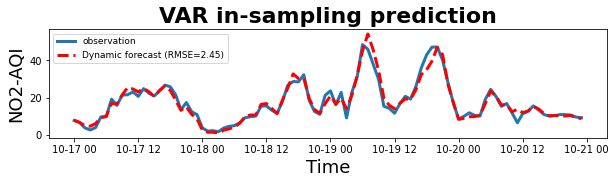

In [ ]:
# Get the lag order
lag_order = model_VAR_2.k_ar

# Prior data for forecasting
prior_data = Pol_weather_df_VAR_train[['NO2', 'CO']].values[384-lag_order:384]

# Forecast VAR model on the training set (from 17 October until 21 October)
prediction_in_sample_1 = model_VAR_2.forecast(y=prior_data, steps=96, exog_future=Pol_weather_df_VAR_train[['NOx','VH']][384:])
prediction_in_sample_1 = pd.DataFrame(prediction_in_sample_1, index=Pol_weather_df_VAR_train[384:].index, columns=['NO2','CO'])

# Reconvert the data
prediction_in_sample_1 = Reconvert_prediction(df_to_convert=prediction_in_sample_1, df_trans=Pol_BA_df_copy, avgs=Pol_BA_df_avgs, devs=Pol_BA_df_devs)

# Visualize the predcition result
prediction_plot_var(Pol_BA_df['NO2']['2020-10-17 00:00:00':'2020-10-20 23:00:00'], prediction_in_sample_1['NO2'], title="VAR in-sampling prediction")

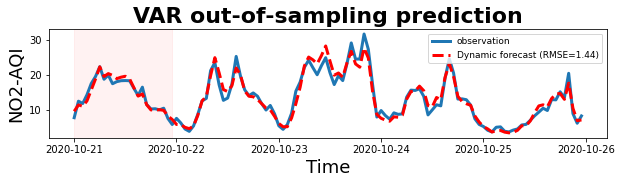

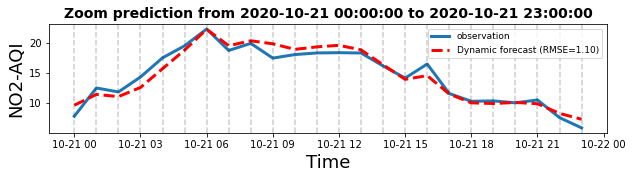

In [ ]:
# Get the lag order
lag_order = model_VAR_2.k_ar

# Prior data for forecasting
prior_data = Pol_weather_df_VAR_train[['NO2', 'CO']].values[384-lag_order:384]

# Forecast VAR model on the training set (from 17 October until 21 October)
prediction_in_sample_1 = model_VAR_2.forecast(y=prior_data, steps=96, exog_future=Pol_weather_df_VAR_train[['NOx','VH']][384:])
prediction_in_sample_1 = pd.DataFrame(prediction_in_sample_1, index=Pol_weather_df_VAR_train[384:].index, columns=['NO2','CO'])

# Reconvert the data
prediction_in_sample_1 = Reconvert_prediction(df_to_convert=prediction_in_sample_1, df_trans=Pol_BA_df_copy, avgs=Pol_BA_df_avgs, devs=Pol_BA_df_devs)

# Visualize the predcition result
prediction_plot_var(Pol_BA_df['NO2']['2020-10-17 00:00:00':'2020-10-20 23:00:00'], prediction_in_sample_1['NO2'], title="VAR in-sampling prediction")

# Prior data for forecasting
prior_data = Pol_weather_df_VAR_train[['NO2', 'CO']].values[-lag_order:]

# Forecast VAR model on the testing set for next 120 hours(from 21 October until 26 October)
prediction_1 = model_VAR_2.forecast(y=prior_data, steps=120, exog_future=Pol_weather_df_VAR_test[['NOx','VH']])
prediction_1 = pd.DataFrame(prediction_1, index=Pol_weather_df_VAR_test.index, columns=['NO2','CO'])

# Reconvert the data
prediction_1 = Reconvert_prediction(df_to_convert=prediction_1, df_trans=Pol_BA_df_copy, avgs=Pol_BA_df_avgs, devs=Pol_BA_df_devs)

# Visualize the predcition result
prediction_plot_var(Pol_BA_df['NO2']['2020-10-21 00:00:00':'2020-10-25 23:00:00'], prediction_1['NO2'], zoom=True, zoom_start_at='2020-10-21 00:00:00', zoom_end_at='2020-10-21 23:00:00')

**==>** From the prediction result, we can see that after adding VH as another exogenous variable, the performance of the VAR model getting better for a long period with lower rmse, which is **the best model until now**. 

**Analyse the correlation among different sensors**

In the next step, we will explore the correlation among different sensors('Sensor Pollution1', Sensor Pollution2 and 'Sensor Pollution3') who are close to each other. By taking the 'NO2' variable separately from Sensor Pollution1, Sensor Pollution2 and Sensor Pollution3, we will try to find an optimal model to deal with the case when Sensor Pollution1 is broken down, we can still predict NO2 based on the record of the two others sensor.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1488 entries, 2020-10-01 00:00:00 to 2020-10-31 23:30:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NO2     1452 non-null   float64
 1   NOx     1452 non-null   float64
dtypes: float64(2)
memory usage: 34.9 KB
None
>>> The first five lines of data: 
                       NO2    NOx
DateTime                        
2020-10-01 00:00:00  8.51  11.19
2020-10-01 00:30:00  7.52   8.19
2020-10-01 01:00:00  4.76   5.97
2020-10-01 01:30:00  5.14   6.73
2020-10-01 02:00:00  5.76   8.17


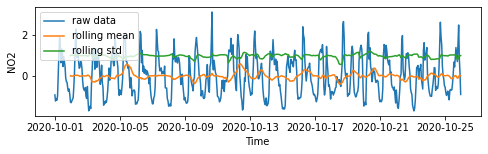

In [ ]:
# Importing pollution data
Pol_JA = pd.read_csv("Pollution_Jagtvej.csv", sep=',', names= ['DateTime','NO2', 'NOx'], header=0, parse_dates=['DateTime'], index_col='DateTime')

# Inspecting pollution data
inspect_data(Pol_JA, visualize_missing_value=False)

# Filling the missing value
Pol_JA = fill_missing_values(Pol_JA)

# Convert pollutant concentration unit(just one time)
Pol_JA = conversion_to_ppb(Pol_JA)

# Select a period of time series and resample it by hours
Pol_JA_df = select_period_resample(Pol_JA, start_at=pd.to_datetime('2020-10-01 00:00:00'), end_at=pd.to_datetime('2020-10-25 23:30:00'), freq='H')

# Copy the data
Pol_JA_df_copy = Pol_JA_df.copy()

# Normalize the data
Pol_JA_df_copy, Pol_JA_df_avgs, Pol_JA_df_devs = nomalize_data(Pol_JA_df_copy)

# Remove Increasing Volatility and Seasonality
Pol_JA_df_copy = remove_volatility_seasonality(Pol_JA_df_copy)

# Update the data
Pol_JA_df_trans = Pol_JA_df_copy[['NO2', 'NOx']]

# Extract NO2
Pol_JA_df_NO2 = Pol_JA_df_trans['NO2'].to_frame()

# Stationary checking by plotting rolling means and variances
plot_rolling_means_variance(Pol_JA_df_NO2, window=24, figsize=(8,2))

# Split the stationary data into training set(before 21th Octover) and testing set(rest)
Pol_JA_df_NO2_train, Pol_JA_df_NO2_test = train_test_split(Pol_JA_df_NO2, start_at='2020-10-01 00:00:00', end_at='2020-10-20 23:30:00')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1488 entries, 2020-10-01 00:00:00 to 2020-10-31 23:30:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NO2     1448 non-null   float64
 1   NOx     1448 non-null   float64
 2   O3      1426 non-null   float64
 3   CO      1453 non-null   float64
dtypes: float64(4)
memory usage: 58.1 KB
None
>>> The first five lines of data: 
                       NO2   NOx     O3    CO
DateTime                                    
2020-10-01 00:00:00  6.79  6.56  73.42  0.15
2020-10-01 00:30:00  5.93  6.04  74.18  0.14
2020-10-01 01:00:00  3.84  3.33  77.05  0.15
2020-10-01 01:30:00  3.71  3.50  75.08  0.15
2020-10-01 02:00:00  4.09  3.31    NaN  0.15


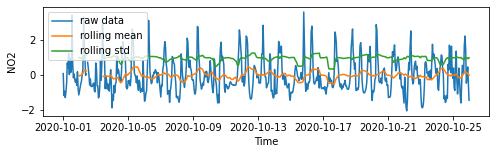

In [ ]:
# Importing pollution data
Pol_ØI = pd.read_csv("Pollution_Ørsted Institutet.csv", sep=',', names= ['DateTime','NO2', 'NOx', 'O3', 'CO'], header=0, parse_dates=['DateTime'], index_col='DateTime')

# Inspecting pollution data
inspect_data(Pol_ØI, visualize_missing_value=False)

# Convert pollutant concentration unit(just one time)
Pol_ØI = conversion_to_ppb(Pol_ØI)

# Select a period of time series and resample it by hours
Pol_ØI_df = select_period_resample(Pol_ØI, start_at=pd.to_datetime('2020-10-01 00:00:00'), end_at=pd.to_datetime('2020-10-25 23:30:00'), freq='H')

# Copy the data
Pol_ØI_df_copy = Pol_ØI_df.copy()

# Normalize the data
Pol_ØI_df_copy, Pol_ØI_df_avgs, Pol_ØI_df_devs = nomalize_data(Pol_ØI_df_copy)

# Remove Increasing Volatility and Seasonality
Pol_ØI_df_copy = remove_volatility_seasonality(Pol_ØI_df_copy)

# Update the data
Pol_ØI_df_trans = Pol_ØI_df_copy[['NO2', 'NOx']]

# Extract NO2
Pol_ØI_df_NO2 = Pol_ØI_df_trans['NO2'].to_frame()

# Stationary checking by plotting rolling means and variances
plot_rolling_means_variance(Pol_ØI_df_NO2, window=24, figsize=(8,2))

# Split the stationary data into training set(before 21th Octover) and testing set(rest)
Pol_ØI_df_NO2_train, Pol_ØI_df_NO2_test = train_test_split(Pol_ØI_df_NO2, start_at='2020-10-01 00:00:00', end_at='2020-10-20 23:30:00')

**==>** After preprocessing, the NO2 time series of sensor Pollution2 and Pollution3 is stationary.

In [ ]:
# Concatenate three NO2 time series
Pol_NO2 = pd.concat([Pol_BA_df_NO2_trans, Pol_ØI_df_NO2, Pol_JA_df_NO2], axis=1)
Pol_NO2.columns = ['Senor1_NO2', 'Senor2_NO2', 'Senor3_NO2']

# Filling the missing value
Pol_NO2 = fill_missing_values(Pol_NO2, fill_value=0)

# Check for causality by returning p-value table
'''The rows are the response variable, columns are predictors. The values in the table are the p-values'''
grangers_causation_matrix(Pol_NO2[['Senor1_NO2', 'Senor2_NO2', 'Senor3_NO2']])

,Senor1_NO2_x,Senor2_NO2_x,Senor3_NO2_x
Senor1_NO2_y,1.0,0.0005,0.0
Senor2_NO2_y,0.0,1.0000,0.0
Senor3_NO2_y,0.0,0.0000,1.0


**==>** From the above, we can see that p-value are all less than the significance level of 0.05, so we can conclude that the three time series are interchangeably causing each other.

**Apply VAR model**

Now we can apply VAR model and we firstly set all the columns as endogenous variable.

In [ ]:
# Split the stationary data into training set(before 21th Octover) and testing set(rest)
Pol_NO2_train, Pol_NO2_test = train_test_split(Pol_NO2, start_at='2020-10-01 00:00:00', end_at='2020-10-20 23:30:00')

# Selecting best order based
model_VAR_3 = VAR(endog=Pol_NO2_train) #, exog=Pol_weather_df_VAR_train[['CO', 'NOx','VH']]
order_VAR = model_VAR_3.select_order(maxlags=12)
order_VAR.summary()

,AIC,BIC,FPE,HQIC
0,-1.504,-1.477,0.2222,-1.494
1,-3.783,-3.677,0.02275,-3.741
2,-4.002,-3.816*,0.01827,-3.929*
3,-4.005*,-3.740,0.01822*,-3.901
4,-3.996,-3.651,0.01838,-3.860
5,-3.982,-3.556,0.01866,-3.814
6,-3.987,-3.482,0.01856,-3.788
7,-3.975,-3.390,0.01878,-3.745
8,-3.961,-3.296,0.01905,-3.699
9,-3.935,-3.191,0.01955,-3.642


**==>** In the above output, the AIC drops to lowest at lag-3, then increases at lag-4 and then continuously drops further. We will go with the lag-3 model.

In [ ]:
# Fitting the model with order p=3
model_VAR_3 = model_VAR_3.fit(maxlags=3, method='ols', ic='aic', verbose=True)
# Print the model coeffients details
model_VAR_3.summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 3, BIC -> 2, FPE -> 3, HQIC -> 2>
Using 3 based on aic criterion


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 08, Jan, 2021
Time:                     08:18:47
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -3.73635
Nobs:                     477.000    HQIC:                  -3.89540
Log likelihood:          -1046.87    FPE:                  0.0183443
AIC:                     -3.99846    Det(Omega_mle):       0.0172373
--------------------------------------------------------------------
Results for equation Senor1_NO2
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.016656         0.024949            0.668           0.504
L1.Senor1_NO2         0.855355         0.050421           16.964           0.000
L1.Senor2_NO2        -0.015888         0.047646        

==> As we have shifted the sensor1_NO2, the model we got for moment t is equivalent to moment t-1. So The model for sensor1_NO2 is:

**sensor1_NO2,t = 0.855 * sensor1_NO2,t-1 - 0.254 * sensor3_NO2,t-1 - 0.157 * sensor1_NO2,t-2 -0.125 *  sensor3_NO2,t-3**



We can now predict the NO2 of sensor1 by just knowing the current NO2 value of sensor3 and the past value of itself.

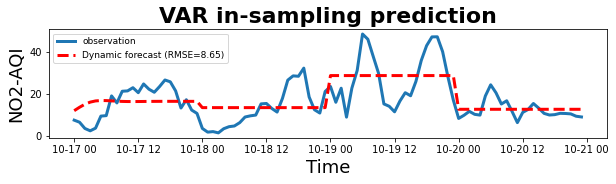

In [ ]:
# Get the lag order
lag_order = model_VAR_3.k_ar

# Prior data for forecasting
prior_data = Pol_NO2.values[384-lag_order:384]

# Forecast VAR model on the training set (from 17 October until 21 October)
prediction_in_sampling = model_VAR_3.forecast(y=prior_data, steps=96)[:,0] #, exog_future=Pol_weather_df_VAR_train[['CO', 'NOx','VH']][384:]
prediction_in_sampling = pd.DataFrame(prediction_in_sampling, index=Pol_BA_df_NO2_train[384:].index, columns=['NO2'])

# Reconvert the data
prediction_in_sampling = Reconvert_prediction(df_to_convert=prediction_in_sampling, df_trans=Pol_BA_df_copy, avgs=Pol_BA_df_avgs, devs=Pol_BA_df_devs)

# Visualize the predcition result
prediction_plot_var(Pol_BA_df['NO2']['2020-10-17 00:00:00':'2020-10-20 23:00:00'], prediction_in_sampling['NO2'], title="VAR in-sampling prediction")

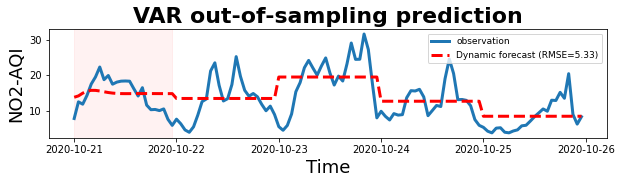

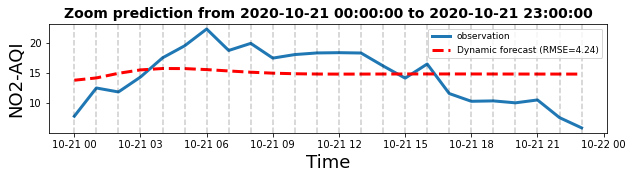

In [ ]:
# Prior data for forecasting
prior_data = Pol_NO2.values[-lag_order:]

# Forecast VAR model on the testing set for next 120 hours(from 21 October until 26 October)
prediction_out_simpling = model_VAR_3.forecast(y=prior_data, steps=120)[:,0] #,exog_future=Pol_weather_df_VAR_test[['CO', 'NOx','VH']]
prediction_out_simpling = pd.DataFrame(prediction_out_simpling, index=Pol_BA_df_NO2_test.index, columns=['NO2'])

# Reconvert the data
prediction_out_simpling_reconvert = prediction_out_simpling.copy()
prediction_out_simpling_reconvert = Reconvert_prediction(df_to_convert=prediction_out_simpling_reconvert, df_trans=Pol_BA_df_copy, avgs=Pol_BA_df_avgs, devs=Pol_BA_df_devs)

# Visualize the predcition result
prediction_plot_var(Pol_BA_df['NO2']['2020-10-21 00:00:00':'2020-10-25 23:00:00'], prediction_out_simpling_reconvert['NO2'], zoom=True, zoom_start_at='2020-10-21 00:00:00', zoom_end_at='2020-10-21 23:00:00')

==> From the figures, we can see that the curve has captured the change in the daily average well, but cannot explain the fluctuations over time. We can assume that the fluctuations come from the impact of CO, NOx, VH.


**Pipeline**

We will now use the prediction result that we have just obtained by putting it as the input data for the model that we have trained previously by taking four factors (NO2,NOx,CO,VH), to check if we can link these two models to make the prediction. It's like creating a pipeline, indeed, we can create a pipeline but here we just do something simple.


In [ ]:
# Concatenate the prediction result with original data
df_final = pd.concat([pd.concat([Pol_BA_df_NO2_trans['2020-10-01 00:00:00':'2020-10-20 23:00:00'], prediction_out_simpling]),Pol_weather_df_VAR['CO']], axis=1)
# Split the data into training set(before 2020-10-21) and testing set(rest)
df_final_train, df_final_test = train_test_split(df_final, start_at='2020-10-01 00:00:00', end_at='2020-10-20 23:30:00')

In [ ]:
# Selecting best order based, setting 'NO2' and 'NOx' as endogenous variable, 'VH' and 'CO' as exogenous variable
model_VAR_final = VAR(endog=df_final[['NO2','CO']], exog=Pol_weather_df_VAR[['NOx','VH']], freq='H')
order_VAR = model_VAR_final.select_order(maxlags=12)
order_VAR.summary()

,AIC,BIC,FPE,HQIC
0,-2.302,-2.258,0.1000,-2.285
1,-3.045,-2.970*,0.04762,-3.016
2,-3.061*,-2.957,0.04684*,-3.020*
3,-3.056,-2.922,0.04705,-3.004
4,-3.047,-2.883,0.04750,-2.983
5,-3.043,-2.849,0.04771,-2.967
6,-3.046,-2.822,0.04756,-2.959
7,-3.052,-2.798,0.04729,-2.953
8,-3.040,-2.757,0.04784,-2.930
9,-3.030,-2.717,0.04833,-2.908


In [ ]:
# Fitting the model with order p=2
model_VAR_final = model_VAR_final.fit(maxlags=2, method='ols', ic='aic', verbose=True)
# Print the model coeffients details
model_VAR_final.summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 2, BIC -> 1, FPE -> 2, HQIC -> 2>
Using 2 based on aic criterion


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 08, Jan, 2021
Time:                     08:49:36
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -2.97023
Nobs:                     598.000    HQIC:                  -3.03304
Log likelihood:          -764.197    FPE:                  0.0462781
AIC:                     -3.07309    Det(Omega_mle):       0.0452134
--------------------------------------------------------------------
Results for equation NO2
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.016496         0.015016            1.099           0.272
exog0          0.494308         0.022197           22.269           0.000
exog1         -0.034164         0.015796           -2.163           0.031
L1.NO2         0

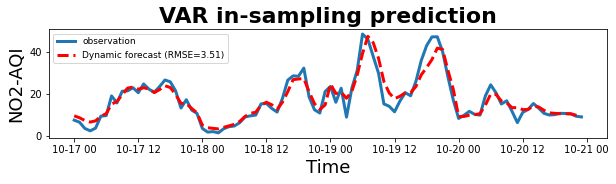

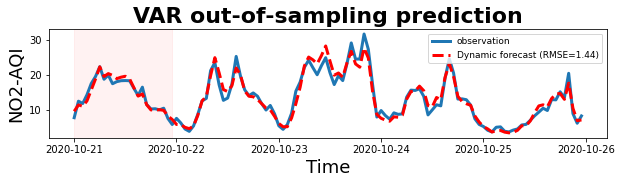

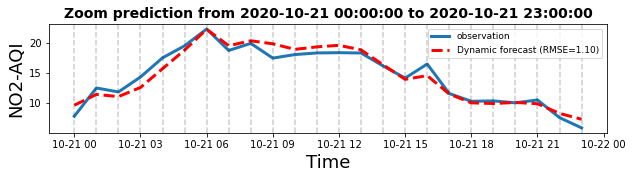

In [ ]:
# Get the lag order
lag_order = model_VAR_final.k_ar

# Prior data for forecasting
prior_data = df_final_train[['NO2', 'CO']].values[384-lag_order:384]

# Forecast VAR model on the training set (from 17 October until 21 October)
prediction_in_sample_final = model_VAR_final.forecast(y=prior_data, steps=96, exog_future=Pol_weather_df_VAR_train[['NOx','VH']][384:])
prediction_in_sample_final = pd.DataFrame(prediction_in_sample_final, index=df_final_train[384:].index, columns=['NO2','CO'])

# Reconvert the data
prediction_in_sample_final = Reconvert_prediction(df_to_convert=prediction_in_sample_final, df_trans=Pol_BA_df_copy, avgs=Pol_BA_df_avgs, devs=Pol_BA_df_devs)

# Visualize the predcition result
prediction_plot_var(Pol_BA_df['NO2']['2020-10-17 00:00:00':'2020-10-20 23:00:00'], prediction_in_sample_final['NO2'], title="VAR in-sampling prediction")

# Prior data for forecasting
prior_data = Pol_weather_df_VAR_train[['NO2', 'CO']].values[-lag_order:]

# Forecast VAR model on the testing set for next 120 hours(from 21 October until 26 October)
prediction_final = model_VAR_2.forecast(y=prior_data, steps=120, exog_future=Pol_weather_df_VAR_test[['NOx','VH']])
prediction_final = pd.DataFrame(prediction_final, index=df_final_test.index, columns=['NO2','CO'])

# Reconvert the data
prediction_final = Reconvert_prediction(df_to_convert=prediction_final, df_trans=Pol_BA_df_copy, avgs=Pol_BA_df_avgs, devs=Pol_BA_df_devs)

# Visualize the predcition result
prediction_plot_var(Pol_BA_df['NO2']['2020-10-21 00:00:00':'2020-10-25 23:00:00'], prediction_final['NO2'], zoom=True, zoom_start_at='2020-10-21 00:00:00', zoom_end_at='2020-10-21 23:00:00')



**Warning level**

Based on this model, we will now predict if the value of pollution will reach the warning level.

We will define 3 different warning levels by ourselves for NO2:
+ Threshold 1: hourly rolling(window=3) average exceeded 'level_1'(AQI)
+ Threshold 2: hourly average exceeded 'level_2'(AQI) for 3 consecutive hours 
+ Threshold 3: hourly average exceeded 'level_3'(AQI)

In [ ]:
# Output the warning prediction result by giving three thresholds
forecast_warning(prediction_final['NO2'], level_1=20, level_2=20, level_3=28)

		Summary of Warning Forecasting Results
 Level 1(AQI) - Hourly Rolling(window=3) Average Exceeds 20
 Level 2(AQI) - Hourly Average Exceeds 20 for 3 consecutive hours
 Level 3(AQI) - Hourly Average Exceeds 28
 -------------------------------------------------------------------------
 Results for Level_1

 Time: 2020-10-21 07:00:00	 Value: 19.570659032967388
 Time: 2020-10-21 08:00:00	 Value: 20.39020297585575
 Time: 2020-10-22 10:00:00	 Value: 20.60967632371122
 Time: 2020-10-22 11:00:00	 Value: 15.845978106952025
 Time: 2020-10-23 07:00:00	 Value: 25.09274357686707
 Time: 2020-10-23 08:00:00	 Value: 24.304509501484077
 Time: 2020-10-23 09:00:00	 Value: 23.17488834892463
 Time: 2020-10-23 10:00:00	 Value: 25.5070190062735
 Time: 2020-10-23 11:00:00	 Value: 28.24532554225462
 Time: 2020-10-23 12:00:00	 Value: 23.976792747239934
 Time: 2020-10-23 13:00:00	 Value: 19.943152447808963
 Time: 2020-10-23 14:00:00	 Value: 20.56206131013247
 Time: 2020-10-23 16:00:00	 Value: 23.481287258266935


**RNN**
**Applying RNN to time series**   
Different to SARIMAX that we can fit the model with datetime indexing data and make predictions just by giving a start time point and end time point, RNN can juste use the array type data and should stretch back to privious seasonal lags point and start making predictions.
First, we should prepare the data from training and testing, and the fit the RNN model and make prediction, finally compare the evalution result to the SARIMAX.

In [ ]:
# Preparing the data
X_train, y_train = preparation_data_rnn(Pol_BA_df_NO2_train, lags=24)
X_test, y_test = preparation_data_rnn(Pol_BA_df_NO2_test, lags=24)

In [ ]:
# Fitting the model
model_RNN = fit_RNN(X=X_train, y=y_train, epochs=200, batch_size=10)

In [ ]:
# Predict a new period
pred = predict_future_rnn(Pol_BA['NO2'], model_RNN, start=pd.to_datetime('2020-10-21 00:00:00'), end=pd.to_datetime('2020-10-22 00:00:00'), lags=24, return_result=True, plot=True)
true = Pol_BA['NO2']['2020-10-21 00:00:00': '2020-10-22 00:00:00'].resample('H').mean()

# Evaluate the predictions
# evaluate(true, pred)

In [128]:
!jupyter nbconvert --to html Copenhague.ipynb

[NbConvertApp] Converting notebook Copenhague.ipynb to html
[NbConvertApp] Writing 3052352 bytes to Copenhague.html
